# Training a Model with PyTorch (intuition_building)

Până în acest moment am reușit să creem un model de Deep Learning cu PyTorch și să facem primele predicții (pe un model care nu a fost antrenat, s-a rulat doar cu acei parametrii cu valorile default). O să recapitulăm ceea ce am învățat până acuma.

In [2]:
# importing the libraries
import torch
import matplotlib.pyplot as plt
from torch import nn


In [3]:
# creating the dataset

# creating the variables
start = 0
end = 1
step = 0.02

# creating the 'known' variables
weight = 0.7
bias = 0.3

# creating the features of the dataset
X = torch.arange(start, end, step).unsqueeze(dim=1)

# creating the labels of the dataset
y = weight * X + bias

# splitting the data into train test and test sets
train_split = int(0.8 *  len(X))

X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

# printing the lenght of the train set and test set
print(f'Lenght of train set Features: {len(X_train)}')
print(f'Lenght of train set labels: {len(y_train)}')

print(f'Lenght of test set Features: {len(X_test)}')
print(f'Lenght of test set labels: {len(y_test)}')


Lenght of train set Features: 40
Lenght of train set labels: 40
Lenght of test set Features: 10
Lenght of test set labels: 10


In [4]:
#  creating a plot to visualize the data

def plot_predictions(
    train_data=X_train,
    train_labels=y_train,
    test_data=X_test,
    test_labels=y_test,
    predictions=None,
    ):
    # creating a figure
    plt.figure(figsize=(10, 7))

    # plotting the training data in blue
    plt.scatter(train_data, train_labels, c="b", s=5, label="Training Data")

    # plotting the test data in green
    plt.scatter(test_data, test_labels, c="g", s=5, label="Test Data")

    # checking if we have predictions
    if predictions is not None:
        # plotting the predictions in red
        plt.scatter(test_data, predictions, c="r", s=5, label="Predictions")

    # displaying the legend
    plt.legend() 

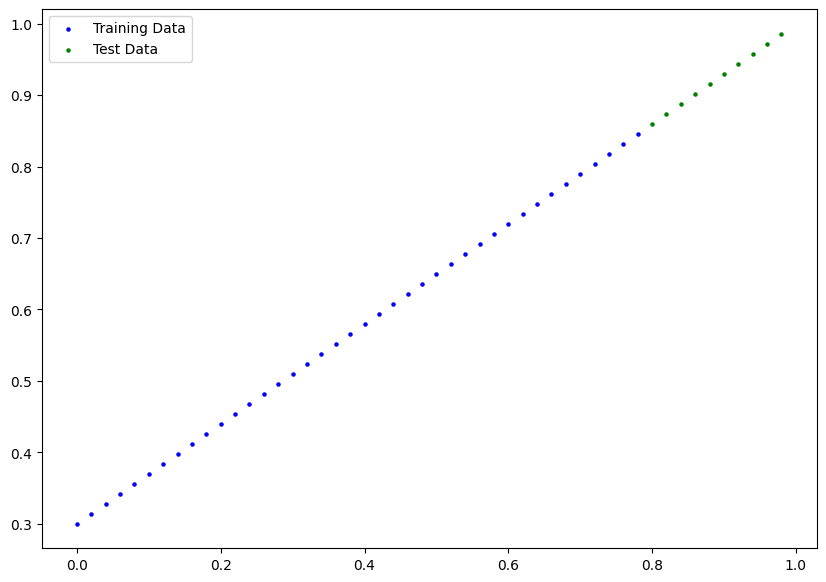

In [5]:
plot_predictions()

In [8]:
# creating a model
class LinearRegressionModel(nn.Module):
    # all models must inherite the nn.Module modul from torch

    # creating the constructor of the class
    def __init__(self):
        # it also must inherit the constructor of the class interited
        super().__init__()

        # creating the parameters
        self.weight = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float32))
        self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float32))

    # overwriting the forward() method
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # all models should overwrite the forward() method
        # this is where we specify what computation need to be made by the model
        return self.weight * x + self.bias

In [9]:
# creating the model
torch.manual_seed(42)
model_0 = LinearRegressionModel()

In [11]:
# making predictions
with torch.inference_mode():
    y_preds = model_0(X_test)

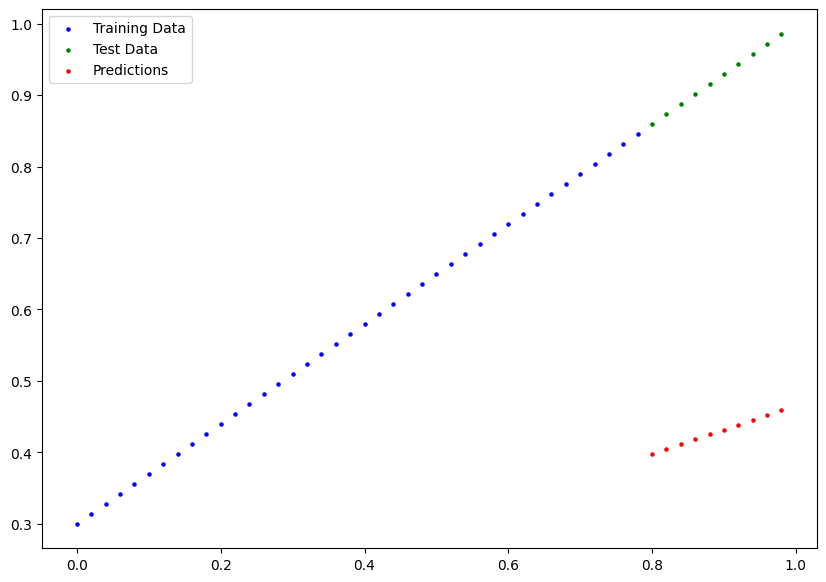

In [13]:
# plotting the prediction
plot_predictions(predictions=y_preds)

După cum am văzut și în cursul anterior, acest model face niște predicții destul de rele. Punctele acelea roșii din grafic ar trebui să fie suprapuse perfect peste punctele verzi din grafic (în cazul în care modelul ar funcționa perfect). Cu cât aceste puncte roșii sunt mai apropiate de punctele verzi, cu atâta modelul nostru performează mai bine. Ca modelul să funcționeze mai bine trebuie să îl antrenăm. Scopul antrenării unui model este să treacă de la anumite valori ale parametrilor necunoscute (alese random de cele mai multe ori) la valorile adevărate (sau cele mai potrivite) ale parametrilor.

Un bun mod de a reprezenta diferența dintre valorile prezise și cele reale (adică cele ce test) este să ne folosim de un `loss function`. Dacă căutăm pe internet care sunt tipurile de **loss function** din PyTorch, o să dăm peste o listă destul de mare. De multe ori, acestea mai poartă și denumirea de **cost functions**. Aceste funcții au scopul de a măsura cât de greșite sunt predicțiile pe care le-a făcut modelul (cu cât rezultatul acestei funcții este mai mic, cu atât mai bine). Atunci când antrenăm un model avem nevoie de un astfel de **loss function**, dar mai avem nevoie și de un `optimizer`. Ce anume face acesta? Un **optimizer** ia in considerare acea eroare a modelului (loss-ul de la acel loss function) și ajustează parametrii modelului pentru a îmbunătăți rezultatul acelei funcții de *loss function*

In [14]:
model_0.state_dict()

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

Modelul cu care lucrăm are doar doi parametrii, dar aceste concepte prin care alegem un `loss function` și un `optimizer` atunci când antrenăm un model se aplică la orice model, chiar dacă avem un model cu sute sau mii de parametrii. Pentru a impleneta acești pași în antrenarea modelului, PyTorch are anumite fincșionalități deja prestabilite pentru a realiza acești pași.

În ceea ce privește partea de setare de **loss function**, PyTorch are un număr destul de mare de unde a alege, iar cum putem să ne dăm seama care este cea mai potrivită, doar prin lucrul al diferite probleme și a încerca diferite funcții pentru a vedea care dintre ele este cea mai potrivită. În ceea ce privește partea de Regresie, cele mai des utilizate sunt `torch.nn.L1Loss` și `torch.nn.MSELoss` (care defapt sunt mean squared error și root mean squared error din Scikit-Learn). Ca și prin exemplu o să folosim ca și *loss function* **torch.nn.L1Loss()**. Această funcție o să o salvăm în cadrul unei variabile pe care o să o denumim loss_fn

In [15]:
loss_fn = nn.L1Loss()

In [16]:
loss_fn

L1Loss()

În ceea ce privește partea de **optimizer**, acesta se va alege din modulul `torch.optim`. Cei mai utilizați optimizatori sunt sunt cei de `SGD` și `Adam`, care au la bază conceptul de **Gradient Descent**

În cazul de față o să utilizăm ca și optimizator SGD, care are nevoie de doi parametrii pentru a putea seta optimizatorul respectiv. Primul este reprezentat de parametrii modelului (pe care îi putem accesa cu cu metoda *model.parameters()*), iar cel de al doilea parametru este denumit `lr` (acornimul de la `learning rate`). Acest al doilea parametru este unul dintre cei mai utilizați hyperparametrii din Machine Learning și Deep Learning. Acestui parametru o să îi setăm ca și valoare un float. Ce anume reprezintă valoarea pe care i-o oferim? Valoarea respectivă reprezintă numărul cu cât să modifice valorile parametrilor modelului (acele valori random alese inițial), fie în sus, fie în jos pentru a ajunge la valorile reale (cele mai potrivite) pe care le poate avea un parametru. O valoarea mai mică înseamnă acuratețe mai mare la model, deoarece acesta modifică valorile parametrilor cu valori mai mici. Partea nnegativă la setarea acestui parametru la valori mai mici este faptul că atunci când avem extrem de mulți parametrii, atunci o să dureze extrem de mult procesul de antrenare a modelului deoarece face modificări extrem de mici la parametrii. Ca și default, valoarea pentru acest parametru este setată la 0.01

In [17]:
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.01)

## Recapitulare

În această parte am învățat următoarele:

1. Care sunt conceptele pe care trebuie să le alegem (implementăm) atunci când antrenăm un model de Deep Learning cu PyTorch

    - Loss Function

    - Optimizer

2. Ce reprezintă aceste procese

    - Loss Function: funcția respectivă determină diferența dintre valorile prezise ale modelului și valorile reale (cele de testare)

    - Optimizer: încearcă să optimizeze parametrii modelului în funcție de rezultatul funcției de loss function

3. Cum setăm un loss function

```python
from torch import nn

loss_fn = nn.L1Loss()
```

4. Cum setăm un optimizator
```python
import torch

optimizer = torch.optim.SGD(model_0.parameters(), lr=0.001)
```